Вам предстоит научитсья моделировать отток клиентов телеком компании. Эта задача очень важна на практике и алгоритмы для ее решения используются в реальных телеком компаниях, ведь если мы знаем, что клиент собирается уйти от нас, то мы попытаться удержать его, предложив какие-то бонусы.

# Импорт библиотек

In [2]:
!pip install catboost
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import catboost

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 44.1 MB/s 


# Работа с данными

## Экспорт данных и их обработка

Здесь не забудьте загрузить train.csv и test.csv из папки Данные.

In [4]:
df = pd.read_csv("/content/train.csv")
df_test = pd.read_csv("/content/test.csv")
df.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [5]:
df.dtypes

ClientPeriod                  int64
MonthlySpending             float64
TotalSpent                   object
Sex                          object
IsSeniorCitizen               int64
HasPartner                   object
HasChild                     object
HasPhoneService              object
HasMultiplePhoneNumbers      object
HasInternetService           object
HasOnlineSecurityService     object
HasOnlineBackup              object
HasDeviceProtection          object
HasTechSupportAccess         object
HasOnlineTV                  object
HasMovieSubscription         object
HasContractPhone             object
IsBillingPaperless           object
PaymentMethod                object
Churn                         int64
dtype: object

In [6]:
df.isnull().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

In [7]:
df.dtypes

ClientPeriod                  int64
MonthlySpending             float64
TotalSpent                   object
Sex                          object
IsSeniorCitizen               int64
HasPartner                   object
HasChild                     object
HasPhoneService              object
HasMultiplePhoneNumbers      object
HasInternetService           object
HasOnlineSecurityService     object
HasOnlineBackup              object
HasDeviceProtection          object
HasTechSupportAccess         object
HasOnlineTV                  object
HasMovieSubscription         object
HasContractPhone             object
IsBillingPaperless           object
PaymentMethod                object
Churn                         int64
dtype: object

In [8]:
columns = list(df.columns)

numeric_columns = ["ClientPeriod", "MonthlySpending", "TotalSpent"]
categorical_columns = []
target_columns = ["Churn"]

# Other columns go to categorical features
for col in columns:
    if (col not in numeric_columns) and (col not in target_columns):
        categorical_columns.append(col)

In [9]:
columns

['ClientPeriod',
 'MonthlySpending',
 'TotalSpent',
 'Sex',
 'IsSeniorCitizen',
 'HasPartner',
 'HasChild',
 'HasPhoneService',
 'HasMultiplePhoneNumbers',
 'HasInternetService',
 'HasOnlineSecurityService',
 'HasOnlineBackup',
 'HasDeviceProtection',
 'HasTechSupportAccess',
 'HasOnlineTV',
 'HasMovieSubscription',
 'HasContractPhone',
 'IsBillingPaperless',
 'PaymentMethod',
 'Churn']

In [10]:
numeric_columns

['ClientPeriod', 'MonthlySpending', 'TotalSpent']

In [11]:
categorical_columns

['Sex',
 'IsSeniorCitizen',
 'HasPartner',
 'HasChild',
 'HasPhoneService',
 'HasMultiplePhoneNumbers',
 'HasInternetService',
 'HasOnlineSecurityService',
 'HasOnlineBackup',
 'HasDeviceProtection',
 'HasTechSupportAccess',
 'HasOnlineTV',
 'HasMovieSubscription',
 'HasContractPhone',
 'IsBillingPaperless',
 'PaymentMethod']

In [12]:
target_columns

['Churn']

In [13]:
assert len(numeric_columns) + len(categorical_columns) + len(target_columns) == 20

In [14]:
print("Categorical columns : [value1, value2, ..., valueN]\n")

for column in categorical_columns:
    print(column, ":", pd.unique(df[column]))

print("\nTarget columns : [value1, value2, ..., valueN]\n")
    
for column in target_columns:
    print(column, ":", pd.unique(df[column]))

Categorical columns : [value1, value2, ..., valueN]

Sex : ['Male' 'Female']
IsSeniorCitizen : [0 1]
HasPartner : ['Yes' 'No']
HasChild : ['Yes' 'No']
HasPhoneService : ['Yes' 'No']
HasMultiplePhoneNumbers : ['No' 'Yes' 'No phone service']
HasInternetService : ['No' 'Fiber optic' 'DSL']
HasOnlineSecurityService : ['No internet service' 'No' 'Yes']
HasOnlineBackup : ['No internet service' 'No' 'Yes']
HasDeviceProtection : ['No internet service' 'No' 'Yes']
HasTechSupportAccess : ['No internet service' 'Yes' 'No']
HasOnlineTV : ['No internet service' 'No' 'Yes']
HasMovieSubscription : ['No internet service' 'No' 'Yes']
HasContractPhone : ['One year' 'Two year' 'Month-to-month']
IsBillingPaperless : ['No' 'Yes']
PaymentMethod : ['Mailed check' 'Credit card (automatic)' 'Electronic check'
 'Bank transfer (automatic)']

Target columns : [value1, value2, ..., valueN]

Churn : [0 1]


## Clear data

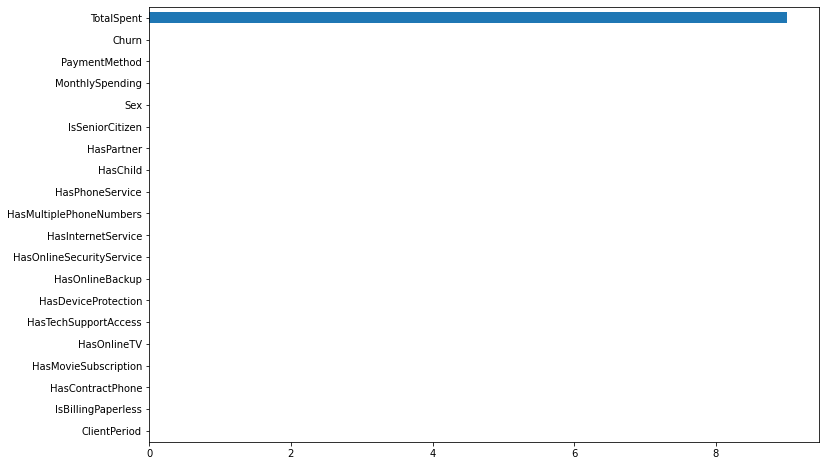

In [15]:
df.replace(" ", np.nan, inplace=True)
df_test.replace(" ", np.nan, inplace=True)

pd.DataFrame(df.isna().sum(), columns=["NaN Count"]) \
    .sort_values("NaN Count") \
    .plot(kind="barh", legend=False, figsize=(12, 8));

У нас 9 Nan, уберём их.

In [16]:
df.sort_values("TotalSpent").tail(15)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
5058,13,78.75,995.35,Female,0,No,No,Yes,Yes,DSL,Yes,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,0
3557,23,44.95,996.85,Female,0,No,No,No,No phone service,DSL,No,No,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,0
141,51,19.85,996.95,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Bank transfer (automatic),0
4317,11,95.15,997.65,Female,1,No,No,Yes,Yes,Fiber optic,No,No,No,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),1
3376,55,19.15,998.1,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Credit card (automatic),0
1157,11,94.20,999.9,Female,0,No,No,Yes,No,Fiber optic,No,Yes,Yes,Yes,No,Yes,Month-to-month,Yes,Electronic check,0
1048,0,25.75,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,NaN,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,NaN,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,NaN,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0


Это новые клиенты, поэтому заполним их нулями

In [17]:
df["TotalSpent"] = df.TotalSpent.fillna(0).astype(float)
df_test["TotalSpent"] = df_test.TotalSpent.fillna(0).astype(float)

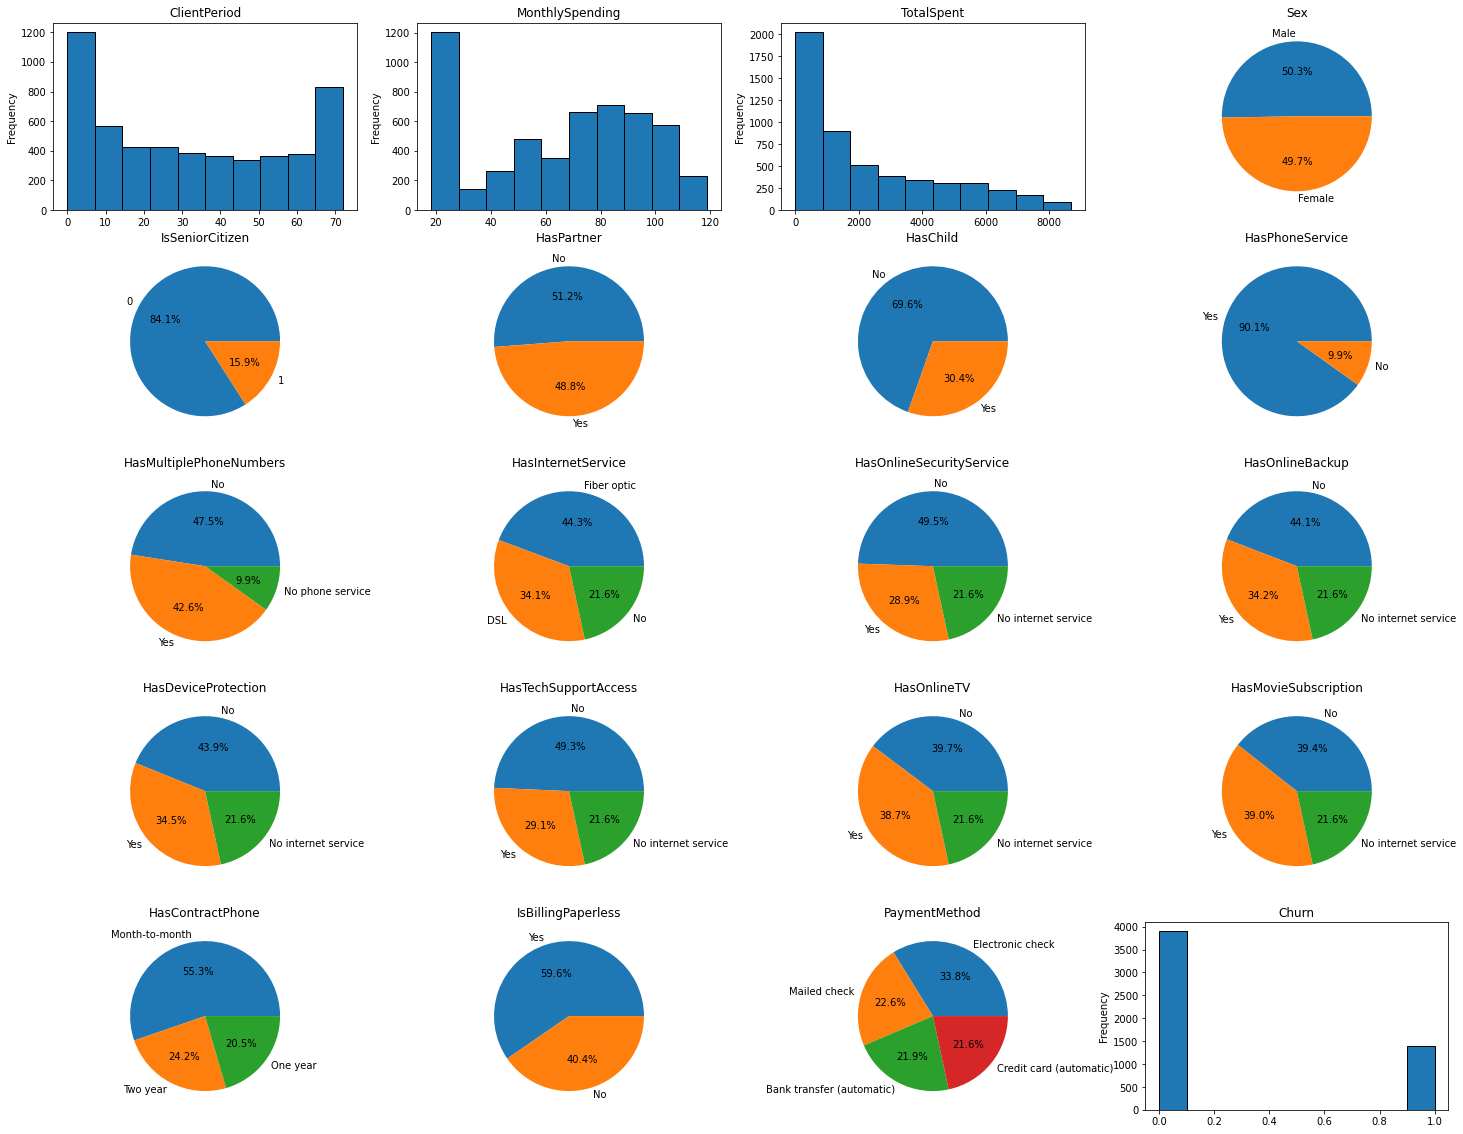

In [18]:
fig, axes = plt.subplots(5, 4, figsize=(25, 20))

for ax, col in zip(axes.flatten(), df.columns):
    ax.set_title(col)
    if col in categorical_columns or col == target_columns:
        ax.pie(df[col].value_counts(), autopct="%1.1f%%", labels=df[col].value_counts().index)
    else:
        df[col].plot(kind="hist", ec="black", ax=ax)

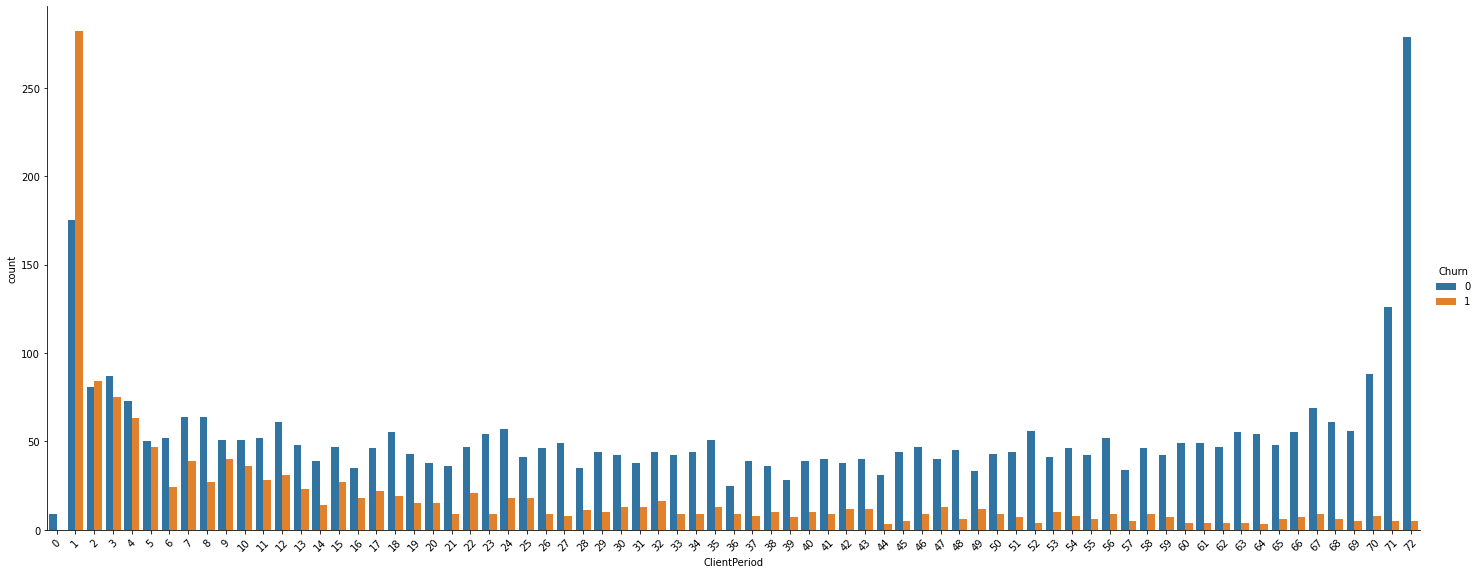

In [19]:
sns.catplot(data=df, x="ClientPeriod", hue="Churn", kind="count", height=8, aspect=20/8)
plt.xticks(rotation=45);

Решите задачу классификации изученными методами. Удачи!